# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# conda install pytorch-cpu -c pytorch for installing pytorch
# pip install torchvision for installing torchvision
from fastai.structured import *
from fastai.column_data import *

np.set_printoptions(threshold=50, edgeitems=20)

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [3]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [4]:
file_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']
file_names

['train',
 'store',
 'store_states',
 'state_names',
 'googletrend',
 'weather',
 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [5]:
files = [pd.read_csv(f'{fname}.csv', low_memory=False) for fname in file_names]

In [6]:
from IPython.display import HTML
from IPython.display import display

We can use `head()` to get a quick look at the contents of each file:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [7]:
for f in files: display(f.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [8]:
for f in files: display(DataFrameSummary(f).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,Bremen,TH
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [9]:
file_names

['train',
 'store',
 'store_states',
 'state_names',
 'googletrend',
 'weather',
 'test']

In [10]:
train, store, store_states, state_names, googletrend, weather, test = files

In [11]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [12]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [13]:
test.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [14]:
display(store.head(2), store_states.head(2), state_names.head(2), googletrend.head(2), weather.head(2))

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


,Store,State
0,1,HE
1,2,TH


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225


In [15]:
# This function merges 2 pandas dataframes.
"""
'join_df' is a function for joining tables on specific fields. 
By default, we'll be doing a left outer join of 'right' on the 'left' argument using the given fields for each table.
Pandas does joins using the 'merge' method. The 'suffixes' argument describes the naming convention for duplicate fields. 
We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.
"""
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [16]:
#Merge weather and statenames.
weather_df = join_df(weather, state_names, left_on='file', right_on='StateName')
weather_df.drop('file', axis=1, inplace=True)
weather_df.head(2)

,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,2013-01-01,8,4,2,7,5,1,94,87,65,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,2013-01-02,7,4,1,5,3,2,93,85,78,...,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW


In [17]:
state_names.shape

(16, 2)

In [18]:
state_names.State.value_counts()

TH       1
SL       1
HB,NI    1
NW       1
RP       1
HH       1
SN       1
ST       1
BW       1
MV       1
HB       1
BB       1
SH       1
HE       1
BY       1
BE       1
Name: State, dtype: int64

In [19]:
state_names[state_names.State=='HB,NI']

,StateName,State
8,Niedersachsen,"HB,NI"


In [20]:
googletrend.head(2)

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95


In [21]:
googletrend.file.str.split('_', expand=True)[2].value_counts()

HE    148
ST    148
BW    148
SL    148
NI    148
TH    148
BY    148
BE    148
RP    148
HH    148
SN    148
NW    148
SH    148
Name: 2, dtype: int64

Lets split the column 'file' so that we pick the state and add a new column state. Lets also split the date timeframe to get the start date and create a new column.
We can see from state_names dataframe that there is no state named NI, but there is a state HB,NI. Inorder to get the statenames as well, lets replace NI as HB,NI in googletrend dataset.

In [22]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [23]:
googletrend.State.value_counts()

HE       148
ST       148
BW       148
SL       148
TH       148
HB,NI    148
BY       148
BE       148
RP       148
HH       148
SN       148
NW       148
SH       148
Name: State, dtype: int64

In [24]:
googletrend.file.value_counts()

Rossmann_DE_BW    148
Rossmann_DE       148
Rossmann_DE_ST    148
Rossmann_DE_SL    148
Rossmann_DE_SH    148
Rossmann_DE_NI    148
Rossmann_DE_NW    148
Rossmann_DE_TH    148
Rossmann_DE_HH    148
Rossmann_DE_SN    148
Rossmann_DE_RP    148
Rossmann_DE_BE    148
Rossmann_DE_BY    148
Rossmann_DE_HE    148
Name: file, dtype: int64

The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [25]:
googletrend.head(2)

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN


In [26]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']
trend_de.head(2)

,file,week,trend,Date,State
148,Rossmann_DE,2012-12-02 - 2012-12-08,77,2012-12-02,None
149,Rossmann_DE,2012-12-09 - 2012-12-15,76,2012-12-09,None


The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

Date fields are present in googletrend, weather, train, test and trend_de dataframes

In [27]:
# add the fields 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
# 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start' to the dataframes having date field
add_datepart(weather_df, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
add_datepart(trend_de, "Date", drop=False)

D:\Anaconda3\lib\site-packages\fastai\structured.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
D:\Anaconda3\lib\site-packages\fastai\structured.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[targ_pre+n] = getattr(fld.dt,n.lower())
D:\Anaconda3\lib\site-packages\fastai\structured.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [28]:
store_df = join_df(store, store_states, left_on='Store', right_on='Store')
store_df.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH


In [29]:
#NOTE train dataframe has Sales & Customers information additionally. This isnt present in test df. Test df has id.

In [30]:
#Join store and test, train data frames
test_df = join_df(test, store_df, left_on = 'Store', right_on='Store')
train_df = join_df(train, store_df, left_on='Store', right_on='Store')

In [31]:
test_df.StoreType.isnull().sum(), train_df.StoreType.isnull().sum(), test_df.shape, train_df.shape

(0, 0, (41088, 31), (1017209, 32))

#### Backup for screwing up the dataframes during testing... 

In [32]:
train_bkp = train_df.copy()
test_bkp = test_df.copy()

In [33]:
#train_df = train_bkp.copy()
#test_df = test_bkp.copy()

Lets join train & test dataframes with the googletrend, germany trend and weather

If we are joining based on State, Year, Month and week, google trend doesnt have the exact info... Hence I'm going to do the merge only based on state, year and week

In [34]:
test_df.shape, train_df.shape

((41088, 31), (1017209, 32))

In [35]:
train_df = join_df(train_df, googletrend, left_on= ['State', 'Year', 'Week'])
test_df = join_df(test_df, googletrend, left_on= ['State', 'Year', 'Week'])

In [36]:
test_df.trend.isnull().sum(), train_df.trend.isnull().sum(), test_df.shape, train_df.shape

(0, 0, (41088, 46), (1017209, 47))

Join test & train dataframes with trend_de for entire Germany

In [37]:
train_df = join_df(train_df, trend_de ,left_on= ['Year', 'Week'], suffix= '_DE')
test_df = join_df(test_df, trend_de ,left_on= ['Year', 'Week'], suffix= '_DE')

In [38]:
test_df.trend_DE.isnull().sum(), train_df.trend_DE.isnull().sum(), test_df.shape, train_df.shape

(0, 0, (41088, 62), (1017209, 63))

In [39]:
train_bkp1 = train_df.copy()
test_bkp1 = test_df.copy()

In [204]:
train_df = train_bkp1.copy()
test_df = test_bkp1.copy()

In [41]:
train_df[(train_df.State == 'HE') & (train_df.Date== '2015-07-31')]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day_DE,Dayofweek_DE,Dayofyear_DE,Is_month_end_DE,Is_month_start_DE,Is_quarter_end_DE,Is_quarter_start_DE,Is_year_end_DE,Is_year_start_DE,Elapsed_DE
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
55,56,5,2015-07-31,10022,619,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
68,69,5,2015-07-31,11204,1371,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
76,77,5,2015-07-31,10335,780,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
110,111,5,2015-07-31,8897,698,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
119,120,5,2015-07-31,10392,794,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
127,128,5,2015-07-31,9581,694,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
129,130,5,2015-07-31,5404,545,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
134,135,5,2015-07-31,7475,619,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
139,140,5,2015-07-31,9828,1085,1,1,0,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600


In [205]:
weather_df[(weather_df.State=='HE') & (weather_df.Date=='2015-07-31')]

,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
7871,2015-07-31,23,16,8,9,6,3,98,54,18,...,31,4,212,True,False,False,False,False,False,1438300800


In [206]:
train_df = join_df(train_df, weather_df, left_on= ["State","Date"])
test_df = join_df(test_df, weather_df, left_on= ["State","Date"])

In [207]:
test_df.Max_TemperatureC.isnull().sum(), train_df.Max_TemperatureC.isnull().sum(), test_df.shape, train_df.shape

(0, 0, (41088, 98), (1017209, 99))

In [208]:
for df in (test_df, train_df):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

for c in train_df.columns:
    if c.endswith('_y'):
        print(c)
        train_df.drop(c, inplace=True, axis=1)

In [209]:
len(train_df.columns), len(test_df.columns)

(74, 73)

In [210]:
#These are the list of columns that has null values
ncols_train = train_df.columns[train_df.isnull().any()].tolist()
ncols_test = test_df.columns[test_df.isnull().any()].tolist()

In [211]:
len(ncols_train), len(ncols_test) #There are 13 null columns and 14 null columns in train & test respectively

(13, 14)

In [50]:
display(train_df[ncols_train].describe())

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Gust_SpeedKm_h,CloudCover
count,1.014567e+06,693861.000000,693861.000000,509178.000000,509178.000000,992564.000000,992564.000000,992564.000000,236167.000000,936890.000000
mean,5.430086e+03,7.222866,2008.690228,23.269093,2011.752774,23.542818,12.127392,7.284987,48.459272,5.521105
std,7.715324e+03,3.211832,5.992644,14.095973,1.662870,9.222368,4.871022,4.771402,13.142078,1.683795
min,2.000000e+01,1.000000,1900.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,21.000000,0.000000
25%,7.100000e+02,4.000000,2006.000000,13.000000,2011.000000,11.000000,10.000000,3.000000,39.000000,5.000000
50%,2.330000e+03,8.000000,2010.000000,22.000000,2012.000000,31.000000,11.000000,8.000000,47.000000,6.000000
75%,6.890000e+03,10.000000,2013.000000,37.000000,2013.000000,31.000000,14.000000,10.000000,55.000000,7.000000
max,7.586000e+04,12.000000,2015.000000,50.000000,2015.000000,31.000000,31.000000,31.000000,111.000000,8.000000


In [51]:
display(test_df[ncols_test].describe())

,Open,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Gust_SpeedKm_h,CloudCover
count,41077.000000,40992.000000,25872.000000,25872.000000,23856.000000,23856.000000,39005.000000,39005.000000,39005.000000,9781.000000,35141.000000
mean,0.854322,5088.583138,7.035250,2008.641929,24.426559,2011.820926,23.857839,12.697962,7.810127,45.245067,4.894681
std,0.352787,7225.487467,3.143015,6.862400,14.161312,1.692166,9.244556,4.592341,4.606982,12.084466,1.832975
min,0.000000,20.000000,1.000000,1900.000000,1.000000,2009.000000,10.000000,5.000000,0.000000,26.000000,1.000000
25%,1.000000,720.000000,4.000000,2006.000000,13.000000,2011.000000,10.000000,10.000000,5.000000,37.000000,4.000000
50%,1.000000,2425.000000,7.000000,2010.000000,22.000000,2012.000000,31.000000,11.000000,9.000000,45.000000,5.000000
75%,1.000000,6480.000000,9.000000,2012.000000,37.000000,2013.000000,31.000000,14.000000,10.000000,52.000000,6.000000
max,1.000000,75860.000000,12.000000,2015.000000,49.000000,2015.000000,31.000000,31.000000,31.000000,89.000000,8.000000


In [52]:
train_df[ncols_train].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null float64
PromoInterval                509178 non-null object
State_DE                     0 non-null object
Max_VisibilityKm             992564 non-null float64
Mean_VisibilityKm            992564 non-null float64
Min_VisibilitykM             992564 non-null float64
Max_Gust_SpeedKm_h           236167 non-null float64
CloudCover                   936890 non-null float64
Events                       774961 non-null object
dtypes: float64(10), object(3)
memory usage: 108.6+ MB


## Imputing Missing Values

### Promo2SinceYear (numeric type), Promo2SinceWeek (numeric type), PromoInterval (Object type)

In [212]:
train_df[['Promo2','Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval']][train_df['Promo2']!=0].isnull().sum()

Promo2             0
Promo2SinceYear    0
Promo2SinceWeek    0
PromoInterval      0
dtype: int64

In [213]:
#This indicates that the Promo2SinceYear & Promo2SinceWeek doesnt have any null values when Promo2 is valid

In [214]:
train_df[['Promo2','Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval']][train_df['Promo2']==0].isnull().sum()

Promo2                  0
Promo2SinceYear    508031
Promo2SinceWeek    508031
PromoInterval      508031
dtype: int64

In [215]:
train_df['Promo2SinceYear'].loc[train_df['Promo2']==0] = train_df['Promo2SinceYear'].fillna(0).astype(np.float64)
train_df['Promo2SinceWeek'].loc[train_df['Promo2']==0] = train_df['Promo2SinceWeek'].fillna(0).astype(np.float64)
train_df['PromoInterval'].loc[train_df['Promo2']==0] = train_df['PromoInterval'].fillna('NA')

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [216]:
#Lets fill the values of Promo2SinceMonth and Promo2SinceWeek to 0 for 'Promo2' ==0
train_df[['Promo2','Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval']][train_df['Promo2']==0].head(2)

,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval
0,0,0.0,0.0,NA
3,0,0.0,0.0,NA


In [217]:
test_df[['Promo2','Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval']][test_df['Promo2']!=0].isnull().sum()

Promo2             0
Promo2SinceYear    0
Promo2SinceWeek    0
PromoInterval      0
dtype: int64

In [218]:
test_df[['Promo2','Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval']][test_df['Promo2']==0].isnull().sum()

Promo2                 0
Promo2SinceYear    17232
Promo2SinceWeek    17232
PromoInterval      17232
dtype: int64

In [219]:
test_df['Promo2SinceYear'].loc[test_df['Promo2']==0] = test_df['Promo2SinceYear'].fillna(0).astype(np.int32)
test_df['Promo2SinceWeek'].loc[test_df['Promo2']==0] = test_df['Promo2SinceWeek'].fillna(0).astype(np.int32)
test_df['PromoInterval'].loc[test_df['Promo2']==0] = test_df['PromoInterval'].fillna('NA')
test_df[['Promo2','Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval']][test_df['Promo2']==0].head(2)

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval
0,0,0.0,0.0,NA
2,0,0.0,0.0,NA


In [220]:
train_df.columns[train_df.isnull().any()].tolist()

['CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'State_DE',
 'Max_VisibilityKm',
 'Mean_VisibilityKm',
 'Min_VisibilitykM',
 'Max_Gust_SpeedKm_h',
 'CloudCover',
 'Events']

### Max_VisibilityKm, Mean_VisibilityKm, Min_VisibilitykM, Max_Gust_SpeedKm_h, CloudCover, Events

In [221]:
train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_VisibilityKm','Mean_VisibilityKm', 'Min_VisibilitykM','Max_Wind_SpeedKm_h',
'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h','Precipitationmm', 'CloudCover','Events','WindDirDegrees']].head(3)

,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,23,16,8,9,6,3,98,54,18,1021,...,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13
1,19,13,7,9,6,3,100,62,25,1021,...,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309
2,21,13,6,10,7,4,100,61,24,1022,...,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354


In [222]:
train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']].isnull().sum()

Max_TemperatureC              0
Mean_TemperatureC             0
Min_TemperatureC              0
Dew_PointC                    0
MeanDew_PointC                0
Min_DewpointC                 0
Max_Humidity                  0
Mean_Humidity                 0
Min_Humidity                  0
Max_Sea_Level_PressurehPa     0
Mean_Sea_Level_PressurehPa    0
Min_Sea_Level_PressurehPa     0
Max_Wind_SpeedKm_h            0
Mean_Wind_SpeedKm_h           0
Precipitationmm               0
WindDirDegrees                0
dtype: int64

I'm going to try predicting Max_VisibilityKm, Mean_VisibilityKm, Min_VisibilitykM, Max_Gust_SpeedKm_h, CloudCover, Events based on the above non-null columns. I will be using ramdom forest regression to predict this.

In [223]:
test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']].isnull().sum()

Max_TemperatureC              0
Mean_TemperatureC             0
Min_TemperatureC              0
Dew_PointC                    0
MeanDew_PointC                0
Min_DewpointC                 0
Max_Humidity                  0
Mean_Humidity                 0
Min_Humidity                  0
Max_Sea_Level_PressurehPa     0
Mean_Sea_Level_PressurehPa    0
Min_Sea_Level_PressurehPa     0
Max_Wind_SpeedKm_h            0
Mean_Wind_SpeedKm_h           0
Precipitationmm               0
WindDirDegrees                0
dtype: int64

In [224]:
train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Max_VisibilityKm'].notnull()]

,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Precipitationmm,WindDirDegrees
0,23,16,8,9,6,3,98,54,18,1021,1018,1015,24,11,0.00,13
1,19,13,7,9,6,3,100,62,25,1021,1019,1017,14,11,0.00,309
2,21,13,6,10,7,4,100,61,24,1022,1019,1017,14,5,0.00,354
3,19,14,9,9,7,4,94,61,30,1019,1017,1014,23,16,0.00,282
4,20,15,10,8,6,5,82,55,26,1020,1018,1016,14,11,0.00,290
5,20,15,10,8,6,5,82,55,26,1020,1018,1016,14,11,0.00,290
6,18,14,8,11,7,4,88,61,33,1019,1017,1014,26,13,0.00,273
7,18,14,8,11,7,4,88,61,33,1019,1017,1014,26,13,0.00,273
8,21,13,6,10,7,4,100,61,24,1022,1019,1017,14,5,0.00,354
9,18,13,8,9,8,4,94,67,30,1020,1019,1017,21,13,0.00,287


In [231]:
# Importing modules
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

### Using Randomforest regression to predict Max_VisibilityKm based on X1 below...

#### For train_df 

In [226]:
X1 = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Max_VisibilityKm'].notnull()]
y1 = train_df['Max_VisibilityKm'][train_df['Max_VisibilityKm'].notnull()]

In [227]:
X1.shape, y1.shape

((992564, 16), (992564,))

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(694794, 16) (694794,) (297770, 16) (297770,)


In [229]:
# 1) Linear Regression
linear = linear_model.LinearRegression()
# Train the model using the training sets and check score
linear.fit(X_train, y_train)
#Predict Output
lin_predicted = linear.predict(X_test)

linear_score = round(linear.score(X_train, y_train) * 100, 2)
linear_score_test = round(linear.score(X_test, y_test) * 100, 2)
#Equation coefficient and Intercept
print('Linear Regression Score: \n', linear_score)
print('Linear Regression Test Score: \n', linear_score_test)
print('Coefficient: \n', linear.coef_)
print('Intercept: \n', linear.intercept_)

Linear Regression Score: 
 30.73
Linear Regression Test Score: 
 30.68
Coefficient: 
 [-2.21541  0.39987 -1.1583   0.69531  1.70266  0.9217  -0.22323 -0.04369 -0.54955  0.45532 -0.34403 -0.10221
 -0.05934  0.14424  0.33891 -0.00267]
Intercept: 
 79.7077447513


In [232]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rf_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Max_VisibilityKm 

In [233]:
X_train = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Max_VisibilityKm'].notnull()]
y_train = train_df['Max_VisibilityKm'][train_df['Max_VisibilityKm'].notnull()]

X_test = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Max_VisibilityKm'].isnull()]

In [234]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [235]:
train_df['Max_VisibilityKm'].isnull().sum()

24645

In [236]:
train_df['Max_VisibilityKm'].loc[train_df['Max_VisibilityKm'].isnull()] = rf_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [237]:
train_df['Max_VisibilityKm'].isnull().sum()

0

#### For test_df 

In [238]:
X1 = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Max_VisibilityKm'].notnull()]
y1 = test_df['Max_VisibilityKm'][test_df['Max_VisibilityKm'].notnull()]

In [239]:
X1.shape, y1.shape

((39005, 16), (39005,))

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(27303, 16) (27303,) (11702, 16) (11702,)


In [241]:
# 1) Linear Regression
linear = linear_model.LinearRegression()
# Train the model using the training sets and check score
linear.fit(X_train, y_train)
#Predict Output
lin_predicted = linear.predict(X_test)

linear_score = round(linear.score(X_train, y_train) * 100, 2)
linear_score_test = round(linear.score(X_test, y_test) * 100, 2)
#Equation coefficient and Intercept
print('Linear Regression Score: \n', linear_score)
print('Linear Regression Test Score: \n', linear_score_test)
print('Coefficient: \n', linear.coef_)
print('Intercept: \n', linear.intercept_)

Linear Regression Score: 
 39.32
Linear Regression Test Score: 
 39.26
Coefficient: 
 [-2.99687  1.16312 -1.79137  1.57318  1.92252  0.94092 -0.05916 -0.36106 -0.45163  0.35706 -0.29143 -0.06718
 -0.17655  0.40083  0.18958 -0.0112 ]
Intercept: 
 90.5371869445


In [242]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rft_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Max_VisibilityKm 

In [243]:
X_train = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Max_VisibilityKm'].notnull()]
y_train = test_df['Max_VisibilityKm'][test_df['Max_VisibilityKm'].notnull()]

X_test = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Max_VisibilityKm'].isnull()]

In [244]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [245]:
test_df['Max_VisibilityKm'].isnull().sum()

2083

In [246]:
test_df['Max_VisibilityKm'].loc[test_df['Max_VisibilityKm'].isnull()] = rft_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [247]:
test_df['Max_VisibilityKm'].isnull().sum()

0

### Using Random forest regression to predict Mean_VisibilityKm based on X1 below...

#### For train_df 

In [248]:
X1 = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Mean_VisibilityKm'].notnull()]
y1 = train_df['Mean_VisibilityKm'][train_df['Mean_VisibilityKm'].notnull()]

In [249]:
X1.shape, y1.shape

((992564, 16), (992564,))

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(694794, 16) (694794,) (297770, 16) (297770,)


In [251]:
# 1) Linear Regression
linear = linear_model.LinearRegression()
# Train the model using the training sets and check score
linear.fit(X_train, y_train)
#Predict Output
lin_predicted = linear.predict(X_test)

linear_score = round(linear.score(X_train, y_train) * 100, 2)
linear_score_test = round(linear.score(X_test, y_test) * 100, 2)
#Equation coefficient and Intercept
print('Linear Regression Score: \n', linear_score)
print('Linear Regression Test Score: \n', linear_score_test)
print('Coefficient: \n', linear.coef_)
print('Intercept: \n', linear.intercept_)

Linear Regression Score: 
 40.74
Linear Regression Test Score: 
 40.81
Coefficient: 
 [-0.21125  0.01641 -0.44932 -0.09474  0.45795  0.35535 -0.11519 -0.20964 -0.06323  0.17027 -0.11047 -0.06422
 -0.04169  0.05919  0.04104 -0.00485]
Intercept: 
 48.9095189689


In [252]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rf_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Mean_VisibilityKm 

In [253]:
X_train = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Mean_VisibilityKm'].notnull()]
y_train = train_df['Mean_VisibilityKm'][train_df['Mean_VisibilityKm'].notnull()]

X_test = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Mean_VisibilityKm'].isnull()]

In [254]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [255]:
train_df['Mean_VisibilityKm'].isnull().sum()

24645

In [256]:
train_df['Mean_VisibilityKm'].loc[train_df['Mean_VisibilityKm'].isnull()] = rf_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [257]:
train_df['Mean_VisibilityKm'].isnull().sum()

0

#### For test_df 

In [258]:
X1 = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Mean_VisibilityKm'].notnull()]
y1 = test_df['Mean_VisibilityKm'][test_df['Mean_VisibilityKm'].notnull()]

In [259]:
X1.shape, y1.shape

((39005, 16), (39005,))

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(27303, 16) (27303,) (11702, 16) (11702,)


In [261]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rft_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Mean_VisibilityKm 

In [262]:
X_train = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Mean_VisibilityKm'].notnull()]
y_train = test_df['Mean_VisibilityKm'][test_df['Mean_VisibilityKm'].notnull()]

X_test = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Mean_VisibilityKm'].isnull()]

In [263]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [264]:
test_df['Mean_VisibilityKm'].isnull().sum()

2083

In [265]:
test_df['Mean_VisibilityKm'].loc[test_df['Mean_VisibilityKm'].isnull()] = rft_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [266]:
test_df['Mean_VisibilityKm'].isnull().sum()

0

### Using Random forest regression to predict Min_VisibilitykM based on X1 below...

#### For train_df 

In [267]:
X1 = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Min_VisibilitykM'].notnull()]
y1 = train_df['Min_VisibilitykM'][train_df['Min_VisibilitykM'].notnull()]

In [268]:
X1.shape, y1.shape

((992564, 16), (992564,))

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(694794, 16) (694794,) (297770, 16) (297770,)


In [270]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rf_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Min_VisibilityKm 

In [271]:
X_train = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Min_VisibilitykM'].notnull()]
y_train = train_df['Min_VisibilitykM'][train_df['Min_VisibilitykM'].notnull()]

X_test = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Min_VisibilitykM'].isnull()]

In [272]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [273]:
train_df['Min_VisibilitykM'].isnull().sum()

24645

In [274]:
train_df['Min_VisibilitykM'].loc[train_df['Min_VisibilitykM'].isnull()] = rf_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [275]:
train_df['Min_VisibilitykM'].isnull().sum()

0

#### For test_df 

In [276]:
X1 = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Min_VisibilitykM'].notnull()]
y1 = test_df['Min_VisibilitykM'][test_df['Min_VisibilitykM'].notnull()]

In [277]:
X1.shape, y1.shape

((39005, 16), (39005,))

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(27303, 16) (27303,) (11702, 16) (11702,)


In [279]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rft_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Min_VisibilityKm 

In [280]:
X_train = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Min_VisibilitykM'].notnull()]
y_train = test_df['Min_VisibilitykM'][test_df['Min_VisibilitykM'].notnull()]

X_test = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Min_VisibilitykM'].isnull()]

In [281]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [282]:
test_df['Min_VisibilitykM'].isnull().sum()

2083

In [283]:
test_df['Min_VisibilitykM'].loc[test_df['Min_VisibilitykM'].isnull()] = rft_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [284]:
test_df['Min_VisibilitykM'].isnull().sum()

0

### Using Random forest regression to predict Max_Gust_SpeedKm_h based on X1 below...

#### For train_df 

In [285]:
X1 = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Max_Gust_SpeedKm_h'].notnull()]
y1 = train_df['Max_Gust_SpeedKm_h'][train_df['Max_Gust_SpeedKm_h'].notnull()]

In [286]:
X1.shape, y1.shape

((236167, 16), (236167,))

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(165316, 16) (165316,) (70851, 16) (70851,)


In [288]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rf_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Max_Gust_SpeedKm_h 

In [289]:
X_train = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Max_Gust_SpeedKm_h'].notnull()]
y_train = train_df['Max_Gust_SpeedKm_h'][train_df['Max_Gust_SpeedKm_h'].notnull()]

X_test = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Max_Gust_SpeedKm_h'].isnull()]

In [290]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [291]:
train_df['Max_Gust_SpeedKm_h'].isnull().sum()

781042

In [292]:
train_df['Max_Gust_SpeedKm_h'].loc[train_df['Max_Gust_SpeedKm_h'].isnull()] = rf_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [293]:
train_df['Max_Gust_SpeedKm_h'].isnull().sum()

0

#### For test_df 

In [294]:
X1 = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Max_Gust_SpeedKm_h'].notnull()]
y1 = test_df['Max_Gust_SpeedKm_h'][test_df['Max_Gust_SpeedKm_h'].notnull()]

In [295]:
X1.shape, y1.shape

((9781, 16), (9781,))

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6846, 16) (6846,) (2935, 16) (2935,)


In [297]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rft_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Max_Gust_SpeedKm_h 

In [298]:
X_train = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Max_Gust_SpeedKm_h'].notnull()]
y_train = test_df['Max_Gust_SpeedKm_h'][test_df['Max_Gust_SpeedKm_h'].notnull()]

X_test = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Max_Gust_SpeedKm_h'].isnull()]

In [299]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [300]:
test_df['Max_Gust_SpeedKm_h'].isnull().sum()

31307

In [301]:
test_df['Max_Gust_SpeedKm_h'].loc[test_df['Max_Gust_SpeedKm_h'].isnull()] = rft_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [302]:
test_df['Max_Gust_SpeedKm_h'].isnull().sum()

0

### Using Random forest regression to predict CloudCover based on X1 below...

#### For train_df 

In [303]:
X1 = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['CloudCover'].notnull()]
y1 = train_df['CloudCover'][train_df['CloudCover'].notnull()]

In [304]:
X1.shape, y1.shape

((936890, 16), (936890,))

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(655823, 16) (655823,) (281067, 16) (281067,)


In [306]:
# Random Forest

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rf_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null CloudCover 

In [307]:
X_train = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['CloudCover'].notnull()]
y_train = train_df['CloudCover'][train_df['CloudCover'].notnull()]

X_test = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['CloudCover'].isnull()]

In [308]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [309]:
train_df['CloudCover'].isnull().sum()

80319

In [310]:
train_df['CloudCover'].loc[train_df['CloudCover'].isnull()] = rf_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [311]:
train_df['CloudCover'].isnull().sum()

0

#### For test_df 

In [312]:
X1 = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['CloudCover'].notnull()]
y1 = test_df['CloudCover'][test_df['CloudCover'].notnull()]

In [313]:
X1.shape, y1.shape

((35141, 16), (35141,))

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(24598, 16) (24598,) (10543, 16) (10543,)


In [315]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rft_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null CloudCover 

In [316]:
X_train = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['CloudCover'].notnull()]
y_train = test_df['CloudCover'][test_df['CloudCover'].notnull()]

X_test = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['CloudCover'].isnull()]

In [317]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [318]:
test_df['CloudCover'].isnull().sum()

5947

In [319]:
test_df['CloudCover'].loc[test_df['CloudCover'].isnull()] = rft_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [320]:
test_df['CloudCover'].isnull().sum()

0

### Using Random forest regression to predict Events based on X1 below...

#### For train_df 

In [323]:
X1 = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Events'].notnull()]
y1 = train_df['Events'][train_df['Events'].notnull()]

In [324]:
X1.shape, y1.shape

((774961, 16), (774961,))

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(542472, 16) (542472,) (232489, 16) (232489,)


In [326]:
# Random Forest

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rf_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


In [327]:
rf_predicted

array(['Rain-Thunderstorm', 'Rain', 'Rain', 'Fog', 'Rain', 'Snow', 'Rain-Snow', 'Rain-Thunderstorm',
       'Fog-Rain', 'Rain', 'Rain', 'Rain', 'Fog-Rain', 'Rain', 'Rain', 'Rain', 'Fog-Snow', 'Rain', 'Rain',
       'Fog-Rain', ..., 'Rain', 'Fog-Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Snow', 'Fog', 'Fog-Rain', 'Rain',
       'Rain', 'Fog-Rain', 'Fog-Rain', 'Rain', 'Rain', 'Fog', 'Rain', 'Rain-Thunderstorm', 'Fog-Rain', 'Rain'], dtype=object)

#### Predicting all non-null Events 

In [328]:
X_train = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Events'].notnull()]
y_train = train_df['Events'][train_df['Events'].notnull()]

X_test = train_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][train_df['Events'].isnull()]

In [329]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
#Predict Output
rf_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [330]:
train_df['Events'].isnull().sum()

242248

In [331]:
rf_predicted

array(['Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', ..., 'Rain', 'Rain', 'Rain', 'Fog', 'Rain',
       'Rain', 'Rain', 'Rain', 'Fog', 'Fog', 'Fog', 'Fog', 'Rain', 'Rain', 'Rain', 'Rain', 'Fog', 'Rain',
       'Rain', 'Fog'], dtype=object)

In [332]:
train_df['Events'].loc[train_df['Events'].isnull()] = rf_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [333]:
train_df['Events'].isnull().sum()

0

#### For test_df 

In [334]:
X1 = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Events'].notnull()]
y1 = test_df['Events'][test_df['Events'].notnull()]

In [335]:
X1.shape, y1.shape

((30933, 16), (30933,))

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21653, 16) (21653,) (9280, 16) (9280,)


In [337]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rft_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 100.0
Random Forest Test Score: 
 100.0
Accuracy: 
 1.0


#### Predicting all non-null Events 

In [338]:
X_train = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Events'].notnull()]
y_train = test_df['Events'][test_df['Events'].notnull()]

X_test = test_df[['Max_TemperatureC','Mean_TemperatureC', 'Min_TemperatureC','Dew_PointC','MeanDew_PointC','Min_DewpointC', 
'Max_Humidity','Mean_Humidity', 'Min_Humidity','Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
'Min_Sea_Level_PressurehPa','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h', 'Precipitationmm', 'WindDirDegrees']][test_df['Events'].isnull()]

In [339]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 100.0


In [340]:
test_df['Events'].isnull().sum()

10155

In [341]:
rft_predicted

array(['Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', ..., 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain', 'Rain',
       'Rain', 'Rain'], dtype=object)

In [351]:
set(rft_predicted)

{'Fog', 'Fog-Rain-Thunderstorm', 'Rain', 'Rain-Thunderstorm'}

In [342]:
test_df['Events'].loc[test_df['Events'].isnull()] = rft_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [343]:
test_df['Events'].isnull().sum()

0

In [368]:
#Lets drop the column 'State_DE' as it has NONE and not relevant for our analysis. All the values are None.
train_df.drop('State_DE', axis=1, inplace=True)
test_df.drop('State_DE', axis=1, inplace=True)

In [369]:
train_df.columns[train_df.isnull().any()].tolist()

['CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear']

In [370]:
test_df.columns[test_df.isnull().any()].tolist()

['Open',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear']

### CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear

CompetitionDistance - distance in meters to the nearest competitor store  
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened  

(5430.085652302903, 2330.0, 0    250.0
 dtype: float64)

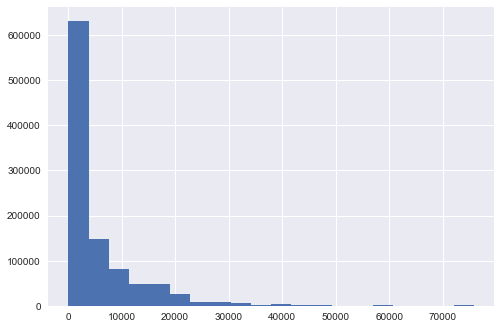

In [389]:
train_df.CompetitionDistance.hist(bins=20)
train_df.CompetitionDistance.mean(), train_df.CompetitionDistance.median(), train_df.CompetitionDistance.mode()

(5088.583138173302, 2425.0, 0    190.0
 1    250.0
 dtype: float64)

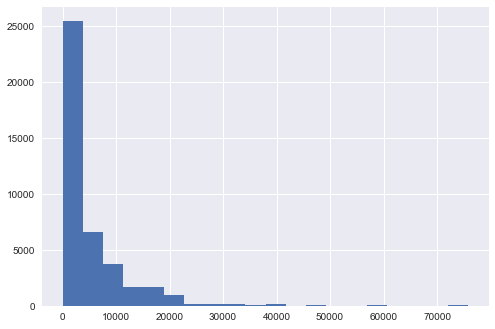

In [390]:
test_df.CompetitionDistance.hist(bins=20)
test_df.CompetitionDistance.mean(), test_df.CompetitionDistance.median(), test_df.CompetitionDistance.mode()

In [411]:
trmode = train_df.CompetitionDistance.mode()
test_df.CompetitionDistance.mode()

0    190.0
1    250.0
dtype: float64

In [413]:
train_df['CompetitionDistance'] = train_df.CompetitionDistance.fillna(train_df.CompetitionDistance.mode()[0]).astype(np.float64)
test_df['CompetitionDistance'] = test_df.CompetitionDistance.fillna(test_df.CompetitionDistance.mode()[0]).astype(np.float64)

In [414]:
train_df['CompetitionDistance'][train_df['CompetitionDistance'].isnull()]
test_df['CompetitionDistance'][test_df['CompetitionDistance'].isnull()]

Series([], Name: CompetitionDistance, dtype: float64)

2008.6902275816049 2010.0 0    2013.0
dtype: float64


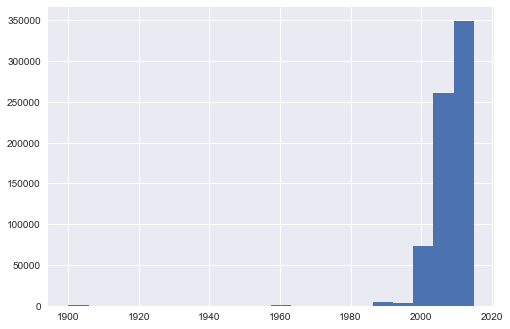

In [415]:
train_df.CompetitionOpenSinceYear.hist(bins=20)
print(train_df.CompetitionOpenSinceYear.mean(), train_df.CompetitionOpenSinceYear.median(), train_df.CompetitionOpenSinceYear.mode())

2008.6419294990724 2010.0 0    2012.0
dtype: float64


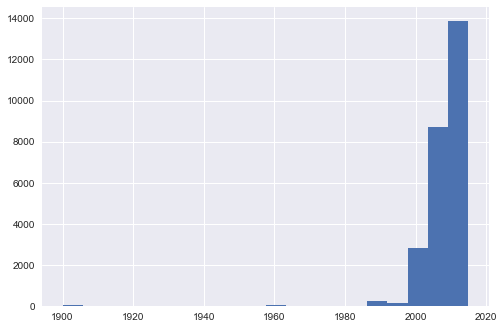

In [416]:
test_df.CompetitionOpenSinceYear.hist(bins=20)
print(test_df.CompetitionOpenSinceYear.mean(), test_df.CompetitionOpenSinceYear.median(), test_df.CompetitionOpenSinceYear.mode())

In [417]:
train_df['CompetitionOpenSinceYear'] = train_df.CompetitionOpenSinceYear.fillna(train_df.CompetitionOpenSinceYear.mode()[0]).astype(np.float64)
test_df['CompetitionOpenSinceYear'] = test_df.CompetitionOpenSinceYear.fillna(test_df.CompetitionOpenSinceYear.mode()[0]).astype(np.float64)

In [418]:
train_df['CompetitionOpenSinceYear'][train_df['CompetitionOpenSinceYear'].isnull()]
test_df['CompetitionOpenSinceYear'][test_df['CompetitionOpenSinceYear'].isnull()]

Series([], Name: CompetitionOpenSinceYear, dtype: float64)

7.222865963067531 8.0 0    9.0
dtype: float64


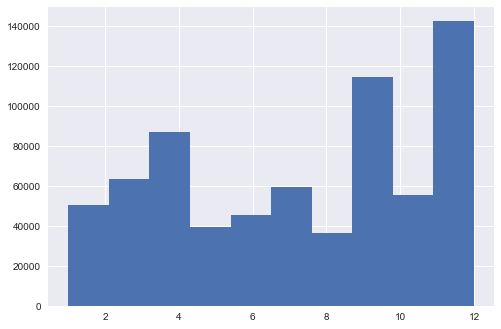

In [419]:
train_df.CompetitionOpenSinceMonth.hist()
print(train_df.CompetitionOpenSinceMonth.mean(), train_df.CompetitionOpenSinceMonth.median(), train_df.CompetitionOpenSinceMonth.mode())

7.0352504638218925 7.0 0    9.0
dtype: float64


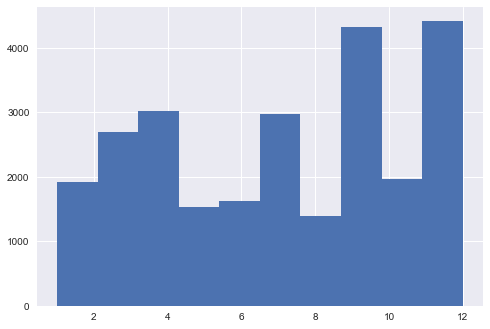

In [420]:
test_df.CompetitionOpenSinceMonth.hist()
print(test_df.CompetitionOpenSinceMonth.mean(), test_df.CompetitionOpenSinceMonth.median(), test_df.CompetitionOpenSinceMonth.mode())

In [422]:
train_df['CompetitionOpenSinceMonth'] = train_df.CompetitionOpenSinceMonth.fillna(train_df.CompetitionOpenSinceMonth.mode()[0]).astype(np.float64)
test_df['CompetitionOpenSinceMonth'] = test_df.CompetitionOpenSinceMonth.fillna(test_df.CompetitionOpenSinceMonth.mode()[0]).astype(np.float64)

In [423]:
train_df['CompetitionOpenSinceMonth'][train_df['CompetitionOpenSinceMonth'].isnull()]
test_df['CompetitionOpenSinceMonth'][test_df['CompetitionOpenSinceMonth'].isnull()]

Series([], Name: CompetitionOpenSinceMonth, dtype: float64)

In [427]:
train_df.columns[train_df.isnull().any()].tolist(), test_df.columns[test_df.isnull().any()].tolist()

([], ['Open'])

### OPEN

In [439]:
test_df[['Store', 'Date', 'Open', 'Year','State' , 'StateHoliday', 'SchoolHoliday']][(test_df.Store==622) & (test_df.Open==0) ]

,Store,Date,Open,Year,State,StateHoliday,SchoolHoliday
3903,622,2015-09-13,0.0,2015,SH,0,0
9895,622,2015-09-06,0.0,2015,SH,0,0
15887,622,2015-08-30,0.0,2015,SH,0,0
21879,622,2015-08-23,0.0,2015,SH,0,0
27871,622,2015-08-16,0.0,2015,SH,0,0
33863,622,2015-08-09,0.0,2015,SH,0,0
39855,622,2015-08-02,0.0,2015,SH,0,0


In [441]:
train_df[['Store', 'Date', 'Open', 'Year','State','StateHoliday', 'SchoolHoliday']][(train_df.Store==622) & (train_df.Open ==0)]

,Store,Date,Open,Year,State,StateHoliday,SchoolHoliday
6196,622,2015-07-26,0,2015,SH,0,0
14001,622,2015-07-19,0,2015,SH,0,0
21806,622,2015-07-12,0,2015,SH,0,0
29611,622,2015-07-05,0,2015,SH,0,0
37416,622,2015-06-28,0,2015,SH,0,0
45221,622,2015-06-21,0,2015,SH,0,0
53026,622,2015-06-14,0,2015,SH,0,0
60831,622,2015-06-07,0,2015,SH,0,0
68636,622,2015-05-31,0,2015,SH,0,0
75326,622,2015-05-25,0,2015,SH,a,0


In [429]:
test_df['Open'].value_counts()

1.0    35093
0.0     5984
Name: Open, dtype: int64

In [467]:
test_df.dtypes[test_df.dtypes == 'datetime64[ns]'].index

Index(['Date', 'Date_DE'], dtype='object')

In [465]:
test_df.dtypes[test_df.dtypes == 'object'].index

Index([], dtype='object')

#### For test_df 

In [468]:
X1 = test_df.drop(['Open','StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State',
       'file', 'week', 'file_DE', 'week_DE', 'Events', 'StateName', 'Date', 'Date_DE'],axis=1)[test_df['Open'].notnull()]
y1 = test_df['Open'][test_df['Open'].notnull()]

In [469]:
X1.shape, y1.shape

((41077, 58), (41077,))

In [470]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28753, 58) (28753,) (12324, 58) (12324,)


In [471]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)

random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(y_test,rft_predicted))
#print(confusion_matrix(y_test,rf_predicted))
#print(classification_report(y_test,rf_predicted))

Random Forest Score: 
 99.92
Random Forest Test Score: 
 99.21
Accuracy: 
 0.992129178838


#### Predicting all non-null Events 

In [472]:
X_train = test_df.drop(['Open','StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State',
       'file', 'week', 'file_DE', 'week_DE', 'Events', 'StateName', 'Date', 'Date_DE'],axis=1)[test_df['Open'].notnull()]
y_train = test_df['Open'][test_df['Open'].notnull()]

X_test = test_df.drop(['Open','StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State',
       'file', 'week', 'file_DE', 'week_DE', 'Events', 'StateName', 'Date', 'Date_DE'],axis=1)[test_df['Open'].isnull()]

In [473]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
#Predict Output
rft_predicted = random_forest.predict(X_test)
random_forest_score = round(random_forest.score(X_train, y_train) * 100, 2)
print('Random Forest Score: \n', random_forest_score)

Random Forest Score: 
 99.93


In [474]:
test_df['Open'].isnull().sum()

11

In [475]:
rft_predicted

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [477]:
test_df['Open'].loc[test_df['Open'].isnull()] = rft_predicted

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [478]:
test_df['Open'].isnull().sum()

0

### Convert all categorical variables 

In [481]:
train_df[train_df['Sales']==0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName
291,292,5,2015-07-31,0,0,0,1,0,1,2015,...,10.0,10.0,23,16,37.5,0.00,6.0,Rain,282,Berlin
875,876,5,2015-07-31,0,0,0,1,0,1,2015,...,24.1,19.9,14,8,32.7,0.00,8.0,Rain,-1,SachsenAnhalt
1406,292,4,2015-07-30,0,0,0,1,0,1,2015,...,11.0,10.0,40,29,61.0,0.00,5.0,Rain,261,Berlin
1990,876,4,2015-07-30,0,0,0,1,0,1,2015,...,27.1,21.4,26,21,41.8,0.00,8.0,Rain,-1,SachsenAnhalt
2521,292,3,2015-07-29,0,0,0,1,0,1,2015,...,10.0,10.0,40,21,55.0,0.00,4.0,Rain,244,Berlin
3105,876,3,2015-07-29,0,0,0,1,0,1,2015,...,26.9,21.4,21,16,33.2,0.25,8.0,Rain,-1,SachsenAnhalt
3636,292,2,2015-07-28,0,0,0,1,0,1,2015,...,10.0,10.0,34,19,52.0,0.00,5.0,Rain,239,Berlin
4220,876,2,2015-07-28,0,0,0,1,0,1,2015,...,22.7,13.6,26,16,41.6,0.00,8.0,Rain,-1,SachsenAnhalt
4751,292,1,2015-07-27,0,0,0,1,0,1,2015,...,13.0,10.0,27,11,34.0,0.25,6.0,Rain-Thunderstorm,188,Berlin
5335,876,1,2015-07-27,0,0,0,1,0,1,2015,...,18.0,6.0,18,10,25.5,6.10,8.0,Rain-Thunderstorm,-1,SachsenAnhalt


In [484]:
train_df.dtypes[train_df.dtypes == 'object'].index

Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State',
       'file', 'week', 'file_DE', 'week_DE', 'Events', 'StateName'],
      dtype='object')

In [502]:
test_df.dtypes[test_df.dtypes == 'object'].index

Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State',
       'file', 'week', 'file_DE', 'week_DE', 'Events', 'StateName'],
      dtype='object')

In [506]:
print(train_df.StateHoliday.value_counts(), test_df.StateHoliday.value_counts())

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64 0    40908
a      180
Name: StateHoliday, dtype: int64


In [488]:
train_df.StoreType.value_counts()

a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64

In [489]:
train_df.Assortment.value_counts()

a    537445
c    471470
b      8294
Name: Assortment, dtype: int64

In [490]:
train_df.PromoInterval.value_counts()

NA                  508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

In [507]:
train_df.Events.value_counts()

Rain                           543344
Fog                            177130
Fog-Rain                        97610
Snow                            58840
Rain-Snow                       49522
Rain-Thunderstorm               47362
Fog-Rain-Thunderstorm           15022
Fog-Snow                         8162
Fog-Rain-Snow                    7246
Rain-Hail                        3097
Thunderstorm                     2725
Rain-Snow-Hail                   2482
Rain-Hail-Thunderstorm           1221
Rain-Snow-Thunderstorm            682
Rain-Snow-Hail-Thunderstorm       483
Snow-Hail                         443
Fog-Thunderstorm                  426
Fog-Rain-Hail-Thunderstorm        420
Fog-Rain-Snow-Hail                398
Fog-Rain-Hail                     308
Fog-Snow-Hail                     286
Name: Events, dtype: int64

In [491]:
train_df.State.value_counts()

NW       269412
BY       136440
SH       108329
HE       105504
BE        86664
SN        70650
BW        68766
ST        52752
RP        37680
TH        33912
HH        26376
HB,NI     20724
Name: State, dtype: int64

In [508]:
#Drop the columns 'file', 'week', 'file_DE', 'week_DE', 'Events'
train_df.drop(['file', 'week', 'file_DE', 'week_DE', 'StateName'], axis=1, inplace=True)
test_df.drop(['file', 'week', 'file_DE', 'week_DE',  'StateName'], axis=1, inplace=True)

In [525]:
test_df.dtypes[test_df.dtypes == 'object'].index

Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State',
       'StateName'],
      dtype='object')

In [526]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['StateHoliday'], prefix = 'StHol')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['StateHoliday'], prefix = 'StHol')], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['StoreType'], prefix = 'StTyp')], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['Assortment'], prefix = 'Ast')], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['PromoInterval'], prefix = 'PrInt')], axis=1)
train_df = pd.concat([train_df, pd.get_dummies(train_df['State'], prefix = 'St')], axis=1)
train_df.drop(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State'], axis=1, inplace=True)
test_df = pd.concat([test_df, pd.get_dummies(test_df['StoreType'], prefix = 'StTyp')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Assortment'], prefix = 'Ast')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['PromoInterval'], prefix = 'PrInt')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['State'], prefix = 'St')], axis=1)
test_df.drop(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'State'], axis=1, inplace=True)

In [527]:
train_df.columns, test_df.columns

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
        'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
        'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'trend', 'trend_DE', 'Date_DE', 'Month_DE', 'Day_DE',
        'Dayofweek_DE', 'Dayofyear_DE', 'Is_month_end_DE', 'Is_month_start_DE',
        'Is_quarter_end_DE', 'Is_quarter_start_DE', 'Is_year_end_DE',
        'Is_year_start_DE', 'Elapsed_DE', 'Max_TemperatureC',
        'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC',
        'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
        'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
        'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_Visibi

In [528]:
test_df['StHol_b'] = 0
test_df['StHol_c'] = 0
test_df['St_BE'] = 0
test_df['St_SN'] = 0
test_df['St_ST'] = 0
test_df['St_TH'] = 0

In [529]:
train_df.shape, test_df.shape

((1017209, 90), (41088, 89))

In [532]:
train_bkp = train_df.copy()
test_bkp = test_df.copy()

In [534]:
train_df.dtypes[train_df.dtypes == 'object'].index

Index([], dtype='object')

### Machine learning 

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [557]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(len(train_df) * train_ratio); train_size
val_idx = list(range(train_size, len(train_df)))
train_size, len(val_idx)

(762906, 254303)

In [558]:
test_df.Date.min(), test_df.Date.max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [559]:
train_df['Date'][(train_df.Date >= '2015-08-01 00:00:00') & (train_df.Date <= '2015-09-17 00:00:00')]
#Unfortunately we dont have any valid data in train dataframe that lies in the date range of test dataframe

Series([], Name: Date, dtype: datetime64[ns])

### Random Forest Regression

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [573]:
train_df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
SchoolHoliday,1,1,1,1,1
Year,2015,2015,2015,2015,2015
Month,7,7,7,7,7


In [568]:
test_df.dtypes[test_df.dtypes == 'datetime64[ns]'].index

Index(['Date', 'Date_DE'], dtype='object')

In [569]:
X = train_df.drop(['Sales', 'Customers', 'Date', 'Date_DE'], axis=1)
y = train_df['Sales']

In [570]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(762906, 85) (762906,) (254303, 85) (254303,)


In [578]:
#rf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2, n_jobs=-1, oob_score=True)
rf = RandomForestRegressor()
rf.fit(X_train, y_train);
rf_predicted = rf.predict(X_test)
random_forest_score = round(rf.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(rf.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)

Random Forest Score: 
 99.02
Random Forest Test Score: 
 94.64


m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [579]:
def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [582]:
rf.score(X_train, y_train), rf.score(X_test, y_test), exp_rmspe(rf_predicted, y_test)
# rf.oob_score_, 

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


(0.99021061658149334, 0.94636640956946583, inf)

In [604]:
?len

In [588]:
X_train = train_df.drop(['Sales', 'Customers', 'Date', 'Date_DE'], axis=1)
y_train = train_df['Sales']
X_test = test_df.drop(['Id', 'Date', 'Date_DE'], axis=1)
X_train.shape, y_train.shape, X_test.shape

((1017209, 85), (1017209,), (41088, 85))

In [589]:
#rf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2, n_jobs=-1, oob_score=True)
rf = RandomForestRegressor()
rf.fit(X_train, y_train);
rf_predicted = rf.predict(X_test)
rf.score(X_train, y_train), rf.score(X_test, y_test), exp_rmspe(rf_predicted, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [254303, 41088]

In [590]:
#We save the submission as a '.csv' file
submission = pd.DataFrame({
        "Id": test_df['Id'],
        "Sales": rf_predicted
    })
submission.to_csv('rossman0510.csv', index=False)

### Feature Engineering 

In [592]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [596]:
rf.feature_importances_

array([ 0.07566,  0.01956,  0.46004,  0.07317,  0.00055,  0.00026,  0.00055,  0.002  ,  0.00582,  0.0135 ,
        0.01473,  0.00323,  0.00006,  0.00037,  0.00005,  0.00024,  0.00001,  0.00553,  0.07954,  0.03012,
       ...,  0.0055 ,  0.00665,  0.00279,  0.00758,  0.00152,  0.00193,  0.00324,  0.00148,  0.01068,
        0.00144,  0.00238,  0.00323,  0.00477,  0.00852,  0.00934,  0.00246,  0.00407,  0.00335,  0.00085,
        0.00158])

In [598]:
pd.DataFrame({'cols':X_train.columns, 'imp':rf.feature_importances_}
                       ).sort_values('imp', ascending=False)[:10]

,cols,imp
2,Open,0.460041
18,CompetitionDistance,0.079535
0,Store,0.075664
3,Promo,0.073168
19,CompetitionOpenSinceMonth,0.030124
20,CompetitionOpenSinceYear,0.027327
1,DayOfWeek,0.019561
23,Promo2SinceYear,0.017276
10,Dayofyear,0.014730
63,StTyp_b,0.013524


In [605]:
#Randomforest with just train data
X = train_df[['Open', 'CompetitionDistance', 'Store', 'Promo', 'CompetitionOpenSinceMonth', 
                   'CompetitionOpenSinceYear', 'DayOfWeek', 'Promo2SinceYear', 'Dayofyear', 'StTyp_b']]
y = train_df['Sales']

In [606]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25, random_state=101)
print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)

(762906, 10) (762906,) (254303, 10) (254303,)


In [607]:
rf1 = RandomForestRegressor()
rf1.fit(X_train1, y_train1);
rf_predicted1 = rf1.predict(X_test1)
random_forest_score = round(rf1.score(X_train1, y_train1) * 100, 2)
random_forest_score_test1 = round(rf1.score(X_test1, y_test1) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test1)

Random Forest Score: 
 98.69
Random Forest Test Score: 
 92.38


In [608]:
rf1.score(X_train1, y_train1), rf1.score(X_test1, y_test1), exp_rmspe(rf_predicted1, y_test1)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


(0.98691706131248391, 0.92376651131579468, inf)

In [632]:
#Random forest prediction for test data
X_train2 = train_df[['Open', 'CompetitionDistance', 'Store', 'Promo', 'CompetitionOpenSinceMonth', 
                   'CompetitionOpenSinceYear', 'DayOfWeek', 'Promo2SinceYear', 'Dayofyear', 'StTyp_b']]
y_train2 = train_df['Sales']
X_test2 = test_df[['Open', 'CompetitionDistance', 'Store', 'Promo', 'CompetitionOpenSinceMonth', 
                   'CompetitionOpenSinceYear', 'DayOfWeek', 'Promo2SinceYear', 'Dayofyear', 'StTyp_b']]
X_train2.shape, y_train2.shape, X_test2.shape

((1017209, 10), (1017209,), (41088, 10))

In [633]:
X_test2.isnull().sum()

Open                         0
CompetitionDistance          0
Store                        0
Promo                        0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
DayOfWeek                    0
Promo2SinceYear              0
Dayofyear                    0
StTyp_b                      0
dtype: int64

In [634]:
#rf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2, n_jobs=-1, oob_score=True)
rf2= RandomForestRegressor()
rf2.fit(X_train2, y_train2)
rf_predicted2 = rf2.predict(X_test2)

In [627]:
rf2.score(X_train2, y_train2)

0.98742660334208598

In [626]:
#We save the submission as a '.csv' file
submission = pd.DataFrame({
        "Id": test_df['Id'],
        "Sales": rf_predicted2
    })
submission.to_csv('rossman05101.csv', index=False)

In [637]:
X_train2.head()

,Open,CompetitionDistance,Store,Promo,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,DayOfWeek,Promo2SinceYear,Dayofyear,StTyp_b
0,1,1270.0,1,1,9.0,2008.0,5,0.0,212,0
1,1,570.0,2,1,11.0,2007.0,5,2010.0,212,0
2,1,14130.0,3,1,12.0,2006.0,5,2011.0,212,0
3,1,620.0,4,1,9.0,2009.0,5,0.0,212,0
4,1,29910.0,5,1,4.0,2015.0,5,0.0,212,0


In [638]:
def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [639]:
test_df.shape, train_df.shape

((41088, 88), (1017209, 89))

### Standard Scaler

scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2', 'x3'])

movies_df['budget'] = MinMaxScaler().fit_transform(movies_df['budget'])
movies_df['vote_average'] = MinMaxScaler().fit_transform(movies_df['vote_average'])
movies_df['vote_count'] = MinMaxScaler().fit_transform(movies_df['vote_count'])

In [641]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

In [642]:
X = train_df.drop(['Sales', 'Customers', 'Date', 'Date_DE'], axis=1)
y = train_df['Sales']

In [652]:
Xcols = X.columns.tolist()

In [654]:
X.shape, y.shape

((1017209, 85), (1017209,))

In [644]:
scaled_X = scaler.fit_transform(X)

In [655]:
scaled_X = pd.DataFrame(scaled_X, columns=Xcols)

In [669]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.25, random_state=101)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(762906, 85) (762906,) (254303, 85) (254303,)


In [670]:
#rf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2, n_jobs=-1, oob_score=True)
rf = RandomForestRegressor()
rf.fit(X_train, y_train);
rf_predicted = rf.predict(X_test)
random_forest_score = round(rf.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(rf.score(X_test, y_test) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)

Random Forest Score: 
 99.03
Random Forest Test Score: 
 94.7


m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [674]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [681]:
rf.score(X_train, y_train), rf.score(X_test, y_test), rmse(rf_predicted, y_test)

(0.99034570593049609, 0.94702183652629612, 885.64492470496202)

### Predicting the test_df

In [683]:
X_train = train_df.drop(['Sales', 'Customers', 'Date', 'Date_DE'], axis=1)
y_train = train_df['Sales']
X_test = test_df.drop(['Id', 'Date', 'Date_DE'], axis=1)
X_train.shape, y_train.shape, X_test.shape

((1017209, 85), (1017209,), (41088, 85))

In [689]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns.tolist())
scaled_X_test = scaler.fit_transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns.tolist())

In [691]:
scaled_X_train.shape, scaled_X_test.shape, y_train.shape

((1017209, 85), (41088, 85), (1017209,))

In [692]:
#rf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2, n_jobs=-1, oob_score=True)
rf = RandomForestRegressor()
rf.fit(scaled_X_train, y_train);
rf_predicted = rf.predict(scaled_X_test)
rf.score(scaled_X_train, y_train)

0.99119087158964714

In [693]:
#We save the submission as a '.csv' file
submission = pd.DataFrame({
        "Id": test_df['Id'],
        "Sales": rf_predicted
    })
submission.to_csv('rossman0511.csv', index=False)

In [694]:
submission.head()

,Id,Sales
0,1,9901.2
1,2,14438.6
2,3,12135.4
3,4,10468.5
4,5,10177.6


In [695]:
#rf.feature_importances_
pd.DataFrame({'cols':X_train.columns, 'imp':rf.feature_importances_}
                       ).sort_values('imp', ascending=False)[:20]

,cols,imp
2,Open,0.459800
18,CompetitionDistance,0.078708
0,Store,0.075056
3,Promo,0.073119
19,CompetitionOpenSinceMonth,0.030712
20,CompetitionOpenSinceYear,0.028236
1,DayOfWeek,0.018232
23,Promo2SinceYear,0.017322
9,Dayofweek,0.014886
10,Dayofyear,0.014149


In [700]:
#Feature Engineering

In [697]:
#Random forest prediction for test data
X_train = train_df[['Open', 'CompetitionDistance', 'Store', 'Promo', 'CompetitionOpenSinceMonth', 
                   'CompetitionOpenSinceYear', 'DayOfWeek', 'Promo2SinceYear', 'DayOfWeek', 'Dayofyear', 
                    'Promo2SinceWeek', 'StTyp_b', 'St_BE', 'St_NW', 'Ast_c']]
y_train = train_df['Sales']
X_test = test_df[['Open', 'CompetitionDistance', 'Store', 'Promo', 'CompetitionOpenSinceMonth', 
                   'CompetitionOpenSinceYear', 'DayOfWeek', 'Promo2SinceYear', 'DayOfWeek', 'Dayofyear', 
                   'Promo2SinceWeek', 'StTyp_b', 'St_BE', 'St_NW', 'Ast_c']]
X_train.shape, y_train.shape, X_test.shape

((1017209, 15), (1017209,), (41088, 15))

In [698]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns.tolist())
scaled_X_test = scaler.fit_transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns.tolist())

In [699]:
scaled_X_train.shape, scaled_X_test.shape, y_train.shape

((1017209, 15), (41088, 15), (1017209,))

In [701]:
#rf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2, n_jobs=-1, oob_score=True)
rf = RandomForestRegressor()
rf.fit(scaled_X_train, y_train);
rf_predicted = rf.predict(scaled_X_test)
rf.score(scaled_X_train, y_train)

0.98823665402077654

In [702]:
#We save the submission as a '.csv' file
submission = pd.DataFrame({
        "Id": test_df['Id'],
        "Sales": rf_predicted
    })
submission.to_csv('rossman05111.csv', index=False)
submission.head()

,Id,Sales
0,1,7903.0
1,2,11489.7
2,3,13774.2
3,4,8356.4
4,5,9517.4


In [703]:
#rf.feature_importances_
pd.DataFrame({'cols':X_train.columns, 'imp':rf.feature_importances_}
                       ).sort_values('imp', ascending=False)[:20]

,cols,imp
0,Open,0.460227
1,CompetitionDistance,0.102557
2,Store,0.093455
3,Promo,0.073400
9,Dayofyear,0.069095
4,CompetitionOpenSinceMonth,0.040190
5,CompetitionOpenSinceYear,0.030655
6,DayOfWeek,0.020540
7,Promo2SinceYear,0.020038
8,DayOfWeek,0.019726
